In [1]:
import os
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import pickle as pkl
import cv2
import numpy as np
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization, Dense, Add, ReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
import random

## Check TF GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Load csv and paths

In [4]:
csv_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train.csv"
train_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_images/"
train_masks_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_masks/"

csv_reducido = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_4sigmoid.csv"

In [5]:
n_w = 1600
n_h = 256

## Create a more balanced dataset with defects and extra 10% without defects

In [6]:
#defective_csv = pd.read_csv(csv_reducido)

defective_csv = pd.read_csv(csv_path)
all_img = [value for value in listdir(train_path)]
defective_img = [value for value in listdir(train_path) if value in list(defective_csv['ImageId'])]
nondefective_img = [value for value in listdir(train_path) if value not in list(defective_csv['ImageId'])]

In [7]:
print(len(defective_img))
print(len(nondefective_img))

6666
5902


In [8]:
idx_aux= np.random.permutation(len(nondefective_img))[0: int(len(defective_img)*0.1)-1]
defective_img = defective_img + [nondefective_img[value] for value in idx_aux]

In [9]:
len(defective_img)

7331

## Train, Test and Validation 

In [10]:
x_train, x_test = model_selection.train_test_split( defective_img, test_size=0.1, random_state=5)
x_train, x_valid = model_selection.train_test_split( x_train, test_size=0.1, random_state=5)

## Functions for inline (RAM) Y defect mask creation

In [11]:
def decode_pixels(pixels_str):
    """
    This function receives a list which contains the pixels as a space-separated code.
    For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask
    """
    
    pixels_encoded_list = pixels_str.split(' ')
    pixels_list = []
    for i in range(0, len(pixels_encoded_list), 2):
        # Add to the pixels list all the pixels encoded by the 2 digits
        pixels_list += range(
            int(pixels_encoded_list[i]) - 1,
            int(pixels_encoded_list[i]) + int(pixels_encoded_list[i + 1]) - 1,
        )
        
    # Return the decoded list    
    return pixels_list

## Data Augmentation Functions

In [12]:
def flip(image, mask , vflip=False, hflip=False):
    '''
    Flip the image
    :param image: image to be processed
    :param vflip: whether to flip the image vertically
    :param hflip: whether to flip the image horizontally
    '''
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
        mask = cv2.flip(mask, flipCode=c)
    return image, mask

def rotate(image, mask, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    mask = cv2.warpAffine(mask,M,(w,h))
    return image, mask
    
def shift(image, mask, px, py):
    w = image.shape[1]
    h = image.shape[0]
    #c = image.shape[2]
    
    img = np.zeros((h,w))
    m = np.zeros((h,w))   
    
    if (py > 0) and (px > 0):
        img[py:, px:] = image[:-py, :-px]
        m[py:, px:] = mask[:-py, :-px]
    elif (py < 0) and (px < 0):
        img[:py, :px] = image[-py:, -px:]
        m[:py, :px] = mask[-py:, -px:]
    elif (py > 0) and (px < 0):
        img[py:, :px] = image[:-py, -px:]
        m[py:, :px] = mask[:-py, -px:]
    elif (py < 0) and (px > 0):
        img[:py, px:] = image[-py:, :-px]
        m[:py, px:] = mask[-py:, :-px]
    
    return img, m

## Data generator for train

In [13]:
# Train Data Generator
def data_generator(ids, batch_size):
    Xs = []; ys = []
    
    while True:
        i = 0
        random.shuffle(ids)
        aug_shift = np.random.randint(2, size=len(ids))
        aug_rot = np.random.randint(2, size=len(ids))
        aug_flip = np.random.randint(2, size=len(ids))
        for id in ids:
            img = cv2.imread(train_path + id)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = img / 255.
            
            mask = make_mask(id)
            
            img=cv2.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)))
            mask=cv2.resize(mask, (int(mask.shape[1]/2),int(mask.shape[0]/2)))
            
            #if aug_shift[i] == 1:
            #    img, mask = shift(img, mask,
            #                      px=np.random.randint(low = -int(img.shape[1]/10),high = int(img.shape[1]/10)),
            #                      py=np.random.randint(low = -int(img.shape[0]/10),high = int(img.shape[0]/10))
            #                     )
            #if aug_rot[i] == 1:
            #    img, mask = rotate(img, mask, angle=np.random.randint(-10,10), scale=1.0 + (random.randint(0,20)/10) )
            #if aug_flip[i] == 1:
            #    img, mask = flip(img, mask, vflip=True, hflip=False)
            #mask = (mask > 0.2) * 1.0
            #
            #i+=1
            
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield (X, y)

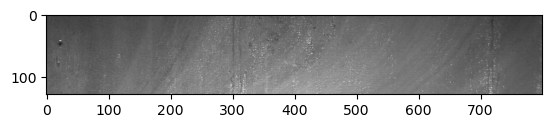

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


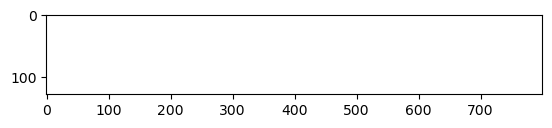

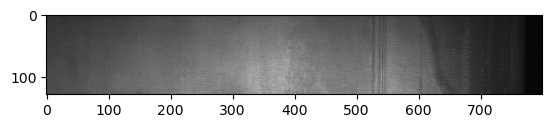

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


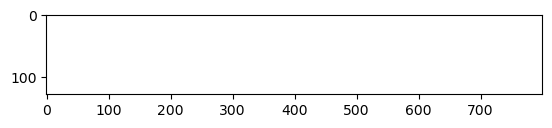

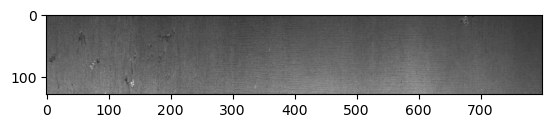

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


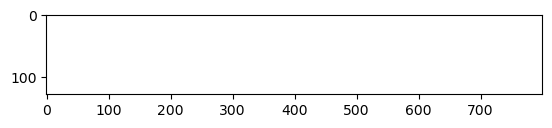

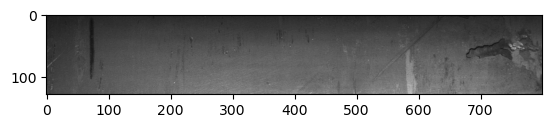

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


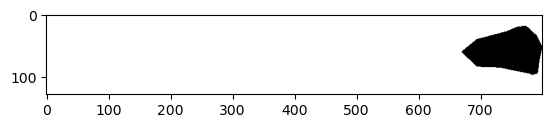

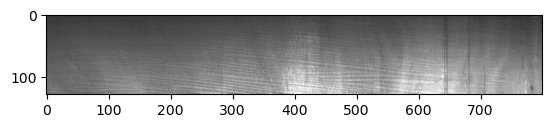

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


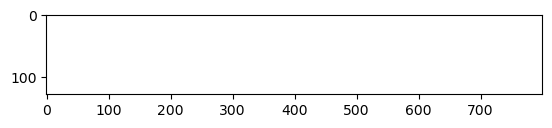

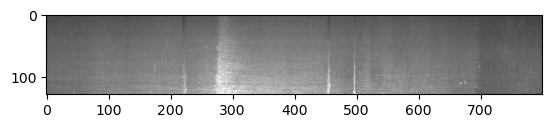

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


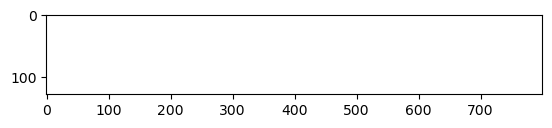

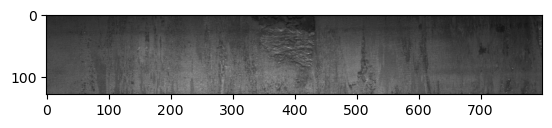

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


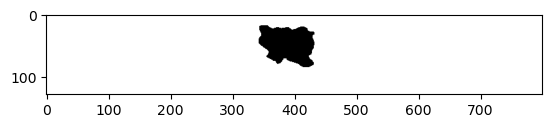

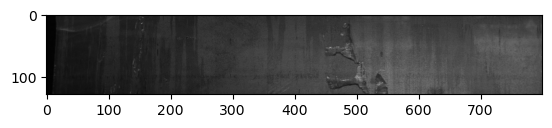

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


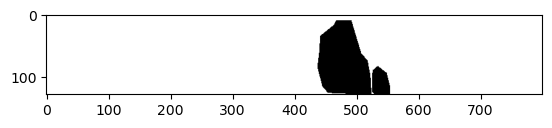

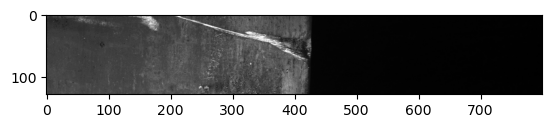

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


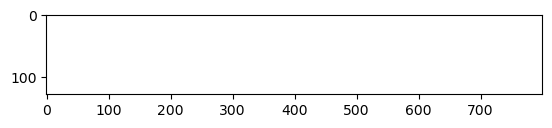

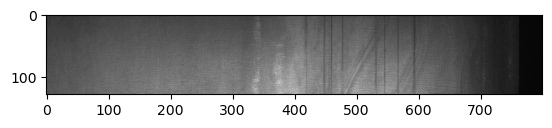

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


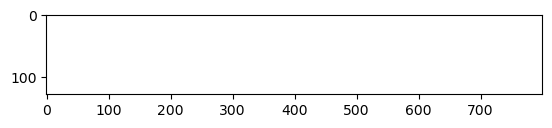

In [18]:
gen = data_generator(x_train,batch_size=10)
for i in range(10):
    data =  next(gen)
    plt.imshow(data[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()
    plt.imshow(data[1][0]*128)
    plt.show()

### Additional usefull metrics

In [14]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice

def dice_coef_nd(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return 2.*intersection, (np.sum(y_true_f)+np.sum(y_pred_f))

def dice_loss(y_true,y_pred):
    return (1 - dice_coef(y_true,y_pred))

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (1 - ((true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)))

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou.numpy()

def iou_coef2(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    if intersection != 0:
        union = K.sum(y_true)+K.sum(y_pred)-intersection
        iou = K.mean((intersection + smooth) / (union + smooth))
        return iou.numpy()
    else:
        return 0

def dice_coef2(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    if intersection != 0:
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth).numpy()
    else:
        return 0


# ResUnet - Inception

In [15]:
def inception_block(prevlayer, a, b):
    
    conva = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    conva = Conv2D(b, (3, 3), activation=None, padding='same')(conva)
    conva = BatchNormalization()(conva)
    conva = ReLU()(conva)
    
    
    convb = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    convb = Conv2D(b, (5, 5), activation=None, padding='same')(convb)
    convb = BatchNormalization()(convb)
    convb = ReLU()(convb)

    convc = Conv2D(b, (1, 1), activation=None, padding='same')(prevlayer)
    convc = BatchNormalization()(convc)
    convc = ReLU()(convc)
        
    convd = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding= 'same')(prevlayer)
    convd = Conv2D(b, (1, 1), activation=None, padding='same')(convd)
    convd = BatchNormalization()(convd)
    convd = ReLU()(convd)
        
        
    up = concatenate([conva, convb, convc, convd])
    return up

In [16]:
def residual_block (input_layer, neurons):
    
    conv1 = Conv2D(neurons , (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1_skip = Conv2D(neurons, 1, 1, activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1_skip = BatchNormalization()(conv1_skip)
    
    added1 = Add()([conv1_skip, conv1])
    relu1 = ReLU()(added1)
    
    return relu1

In [17]:
def build_model(input_layer, start_neurons):
    
    conv1 = residual_block(input_layer,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    conv2 = residual_block(pool1,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    conv3 = residual_block(pool2,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    conv4 = residual_block(pool3,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)

    # Mitad
    convm = inception_block (pool4, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)

    deconv4 = Conv2DTranspose(start_neurons * 8, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(0.5)(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)

    deconv3 = Conv2DTranspose(start_neurons * 4, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(0.5)(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)

    deconv2 = Conv2DTranspose(start_neurons * 2, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    #uconv2 = Dropout(0.5)(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.5)(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    return output_layer

input_layer = Input((128, 800, 1))
output_layer = build_model(input_layer, 8)

model = Model(input_layer, output_layer)


In [18]:
model.load_weights('./weights/resUnetInceptionV5/resUnetInceptionV5')

## Model 2
## U-Net Model with 4 sigmoid to detect presence or not of each class independently

In [17]:
n_class = 4
def make_mask(ImageId):
    
    y_out=defective_csv[defective_csv['ImageId'].eq(ImageId)]
    
    image_pixels = np.zeros((n_h, n_w,n_class), dtype=np.float32)

    for index, row in y_out.iterrows():

        # Generate the mask of the error type
        mask = np.zeros((n_h * n_w, 1), dtype=np.float32)
        mask[decode_pixels(row['EncodedPixels'])] = 1
        mask = mask.reshape(n_w, n_h)
        mask = mask.T
    
        # Update channel of the given error
        image_pixels [:,:,int(row['ClassId'])-1] = np.logical_or(image_pixels [:,:,int(row['ClassId'])-1],mask)
        
    return image_pixels

In [20]:
def build_model2(input_layer, start_neurons):
    
    uconv1 = residual_block(input_layer,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    output_layer1 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    uconv2 = residual_block(input_layer,start_neurons * 1)
    uconv2 = residual_block(uconv2,start_neurons * 1)
    output_layer2 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv2)
    
    uconv3 = residual_block(input_layer,start_neurons * 1)
    uconv3 = residual_block(uconv3,start_neurons * 1)
    output_layer3 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv3)
    
    uconv4 = residual_block(input_layer,start_neurons * 1)
    uconv4 = residual_block(uconv4,start_neurons * 1)
    output_layer4 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv4)
    
    uconvf = concatenate([output_layer1, output_layer2, output_layer3, output_layer4])
    
    return uconvf

output_layer = build_model2(model.layers[-4].output,4)

model2 = Model(model.layers[0].input, output_layer)

In [21]:
model2.load_weights('./weights/resUnetInception4Sigmoid_5epocas_v1/resUnetInception4Sigmoid_25epocas_v4')

In [22]:
optimizer = Adam()
#model2.compile(loss=tversky, optimizer=optimizer, metrics=[dice_coef])
#model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef])
model2.compile(optimizer, dice_loss, metrics=[dice_coef])

In [23]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 800, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 800, 8)  208         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 800, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 800, 8)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

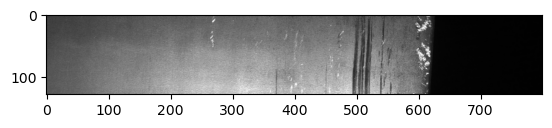

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


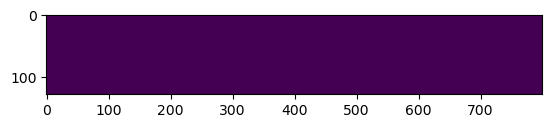

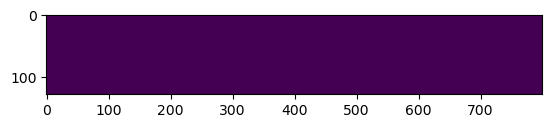

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


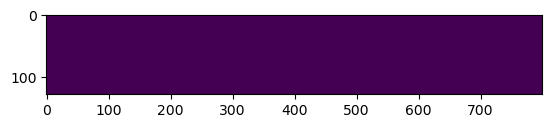

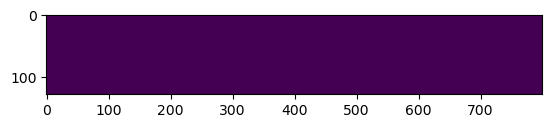

Falla tipo: 3 - IOU: 0.6459376215934753 - DICE: 0.7848761677742004


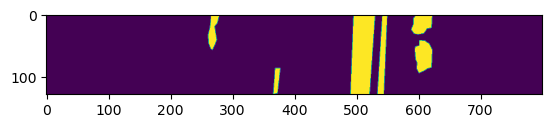

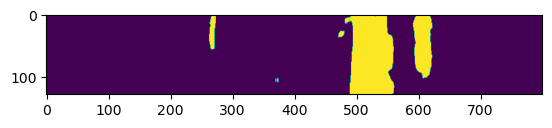

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


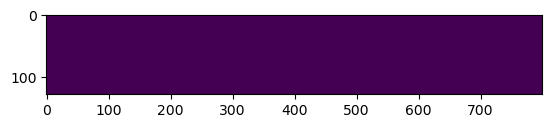

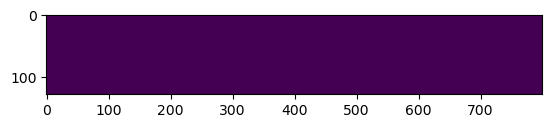

Mean IOU: 0.9114844053983688
Mean DICE: 0.9462190270423889
Keras-IOU: 0.8070858716964722


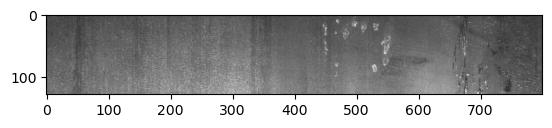

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


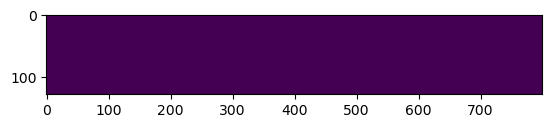

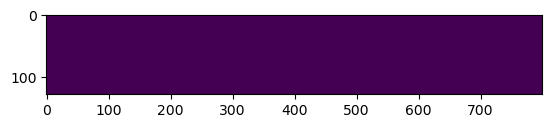

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


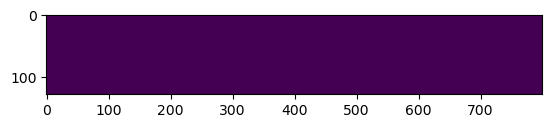

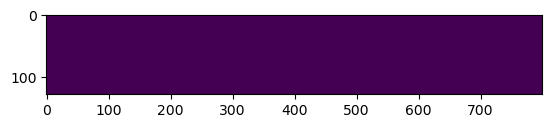

Falla tipo: 3 - IOU: 0.00023005693219602108 - DICE: 0.00023005693219602108


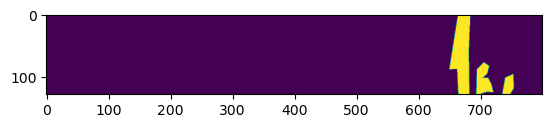

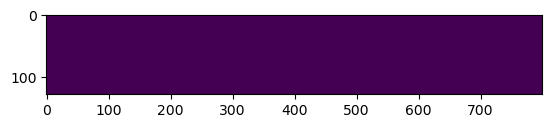

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


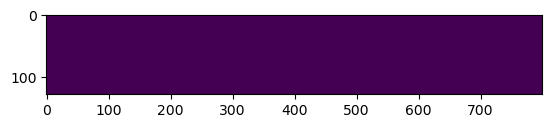

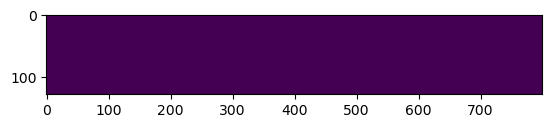

Mean IOU: 0.750057514233049
Mean DICE: 0.7500575184822083
Keras-IOU: 0.49485352635383606


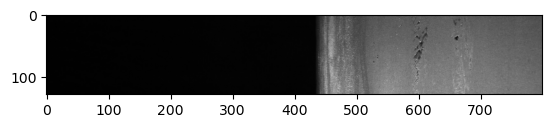

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


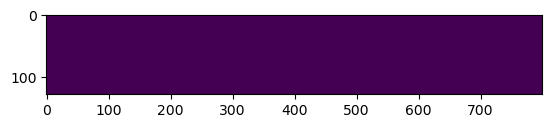

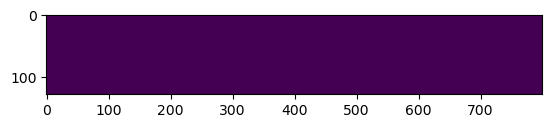

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


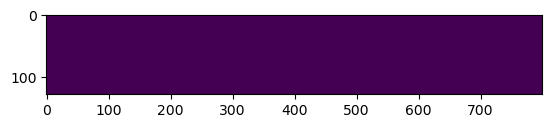

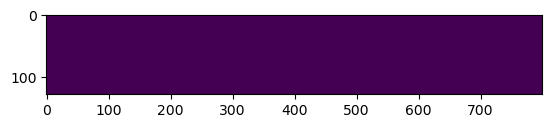

Falla tipo: 3 - IOU: 0.346731036901474 - DICE: 0.5147547125816345


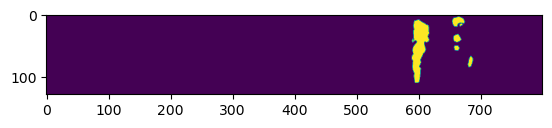

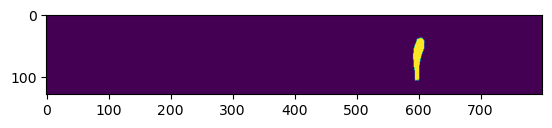

Falla tipo: 4 - IOU: 0.031916920095682144 - DICE: 0.031916920095682144


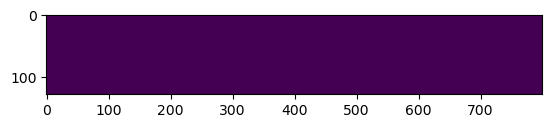

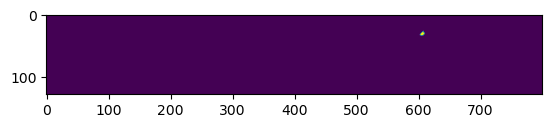

Mean IOU: 0.594661989249289
Mean DICE: 0.6366679072380066
Keras-IOU: 0.5713022351264954


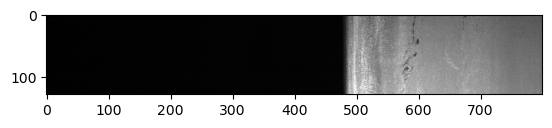

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


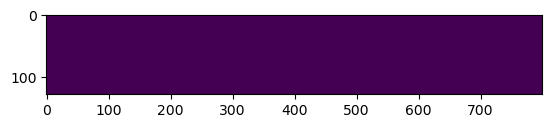

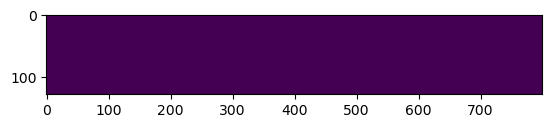

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


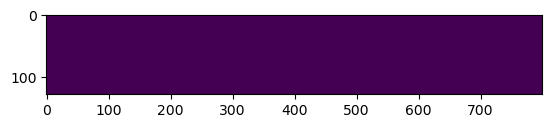

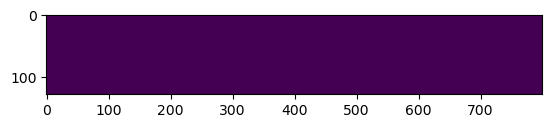

Falla tipo: 3 - IOU: 0.5582693815231323 - DICE: 0.7164566516876221


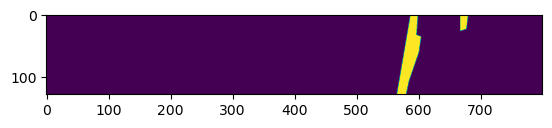

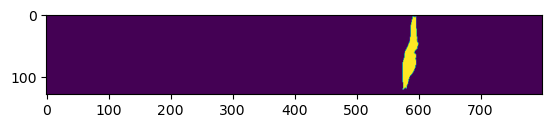

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


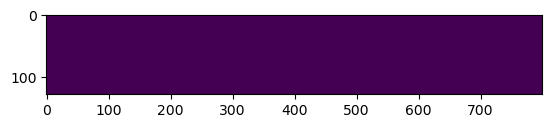

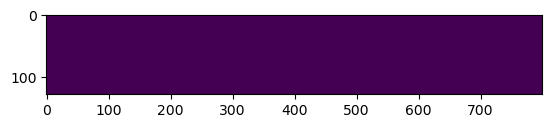

Mean IOU: 0.8895673453807831
Mean DICE: 0.9291141629219055
Keras-IOU: 0.5853248238563538


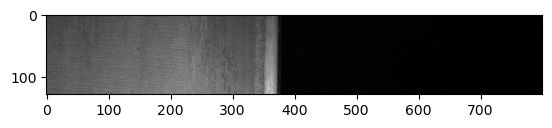

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


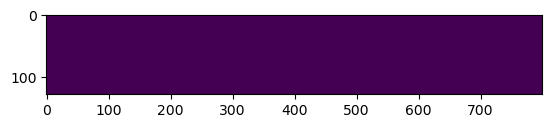

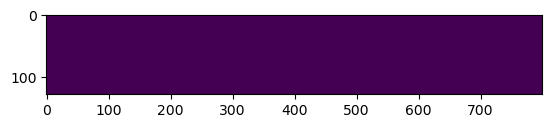

Falla tipo: 2 - IOU: 0.0014184396713972092 - DICE: 0.0014184396713972092


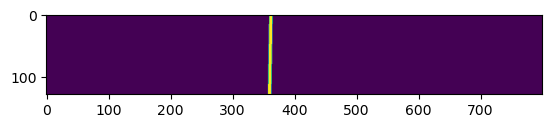

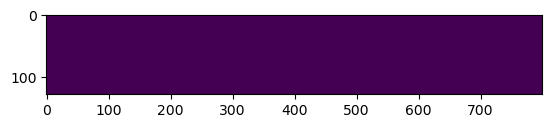

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


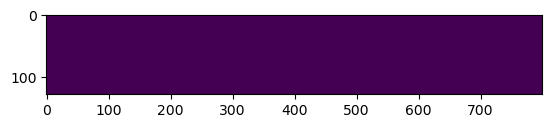

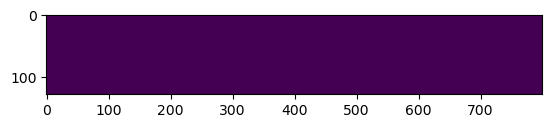

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


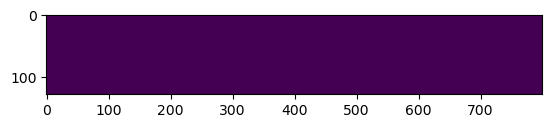

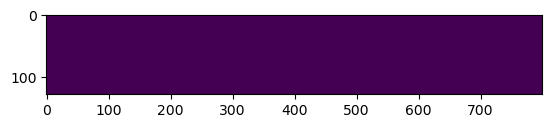

Mean IOU: 0.7503546099178493
Mean DICE: 0.7503546476364136
Keras-IOU: 0.49921876192092896


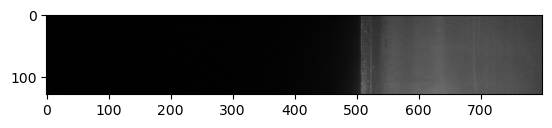

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


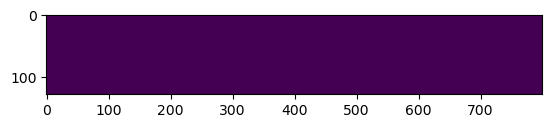

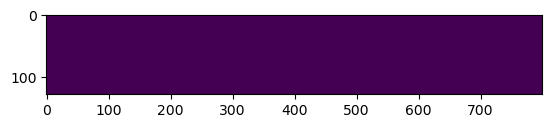

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


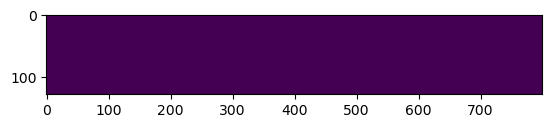

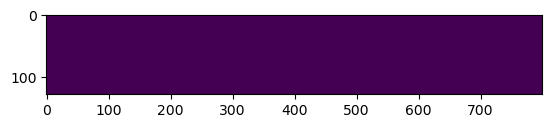

Falla tipo: 3 - IOU: 0.0009908347856253386 - DICE: 0.0009908347856253386


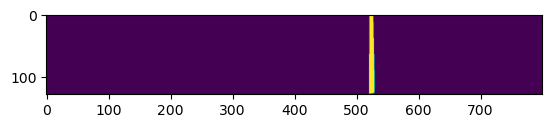

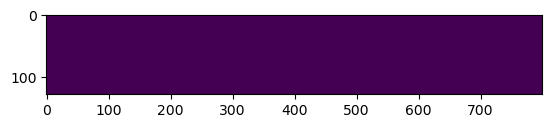

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


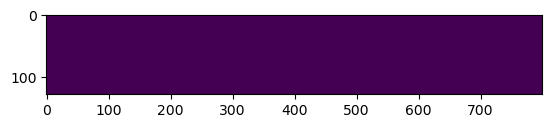

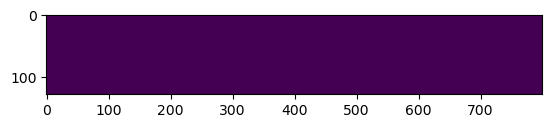

Mean IOU: 0.7502477086964063
Mean DICE: 0.7502477169036865
Keras-IOU: 0.4988452196121216


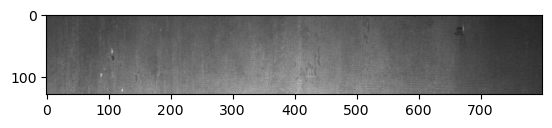

Falla tipo: 1 - IOU: 0.0007914523012004793 - DICE: 0.0007914523012004793


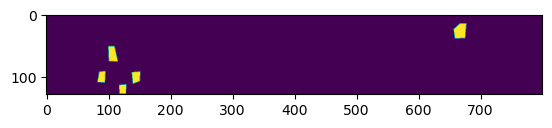

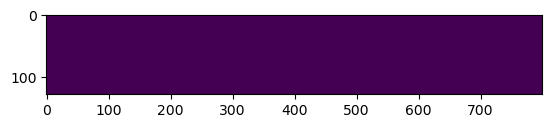

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


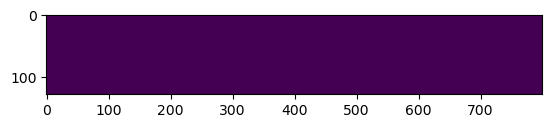

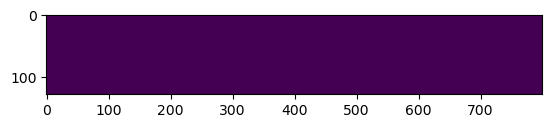

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


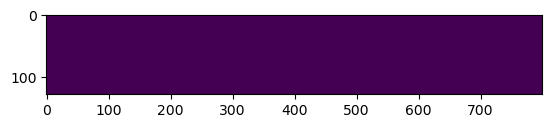

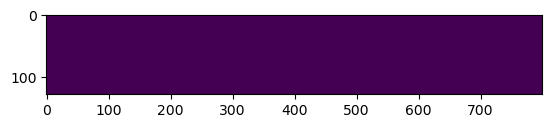

Falla tipo: 4 - IOU: 0.05315421521663666 - DICE: 0.05315421521663666


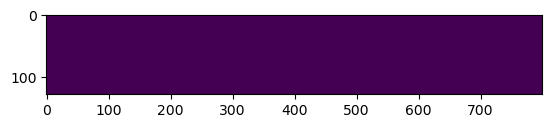

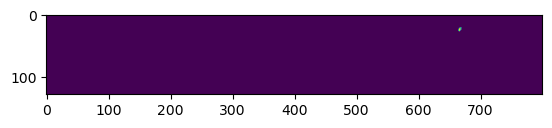

Mean IOU: 0.5134864168794593
Mean DICE: 0.5134864449501038
Keras-IOU: 0.4985693395137787


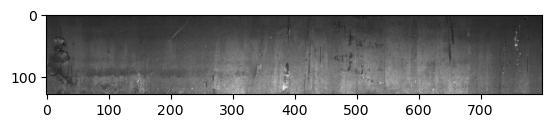

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


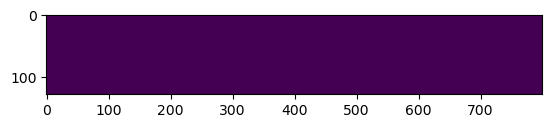

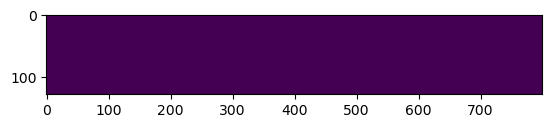

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


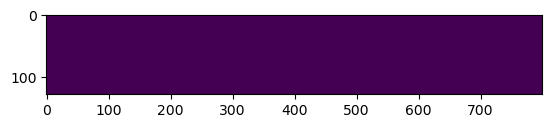

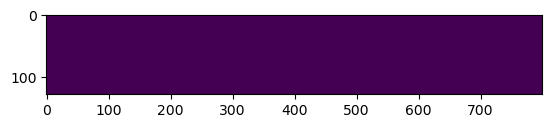

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


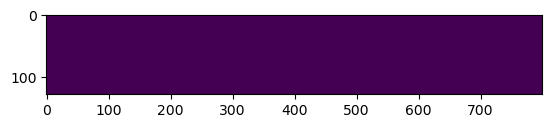

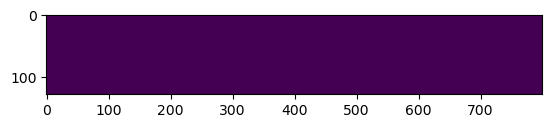

Falla tipo: 4 - IOU: 0.7116803526878357 - DICE: 0.8315243124961853


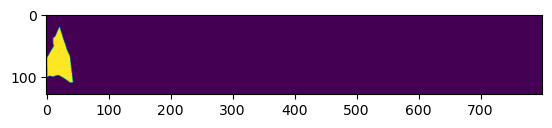

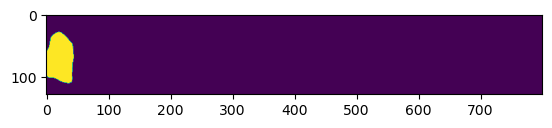

Mean IOU: 0.9279200881719589
Mean DICE: 0.9578810930252075
Keras-IOU: 0.8736811876296997


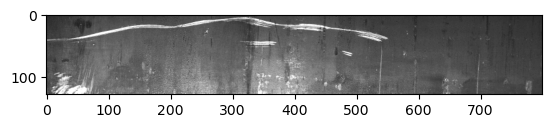

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


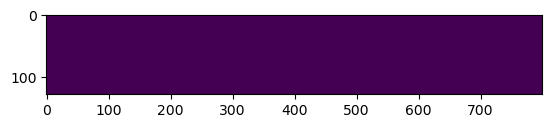

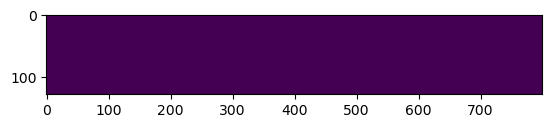

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


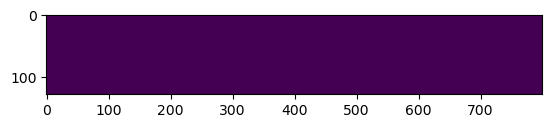

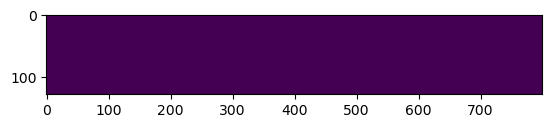

Falla tipo: 3 - IOU: 0.40203315019607544 - DICE: 0.5734831690788269


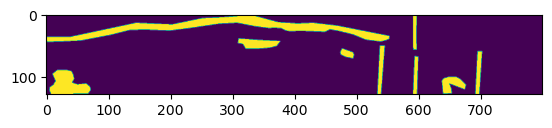

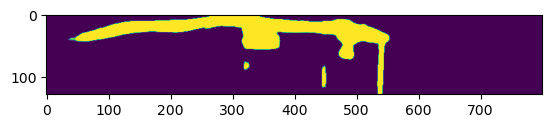

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


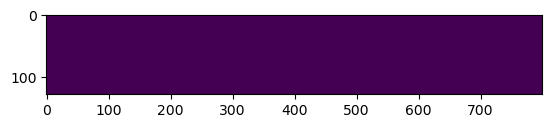

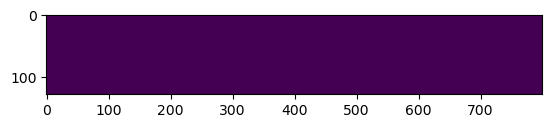

Mean IOU: 0.8505082875490189
Mean DICE: 0.8933708071708679
Keras-IOU: 0.6565977931022644


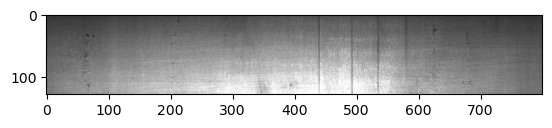

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


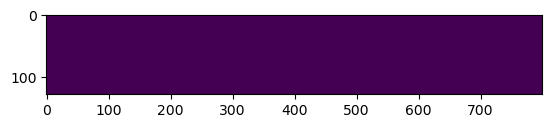

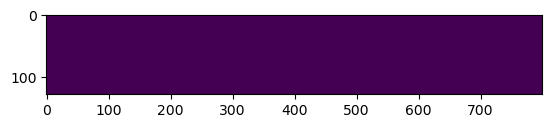

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


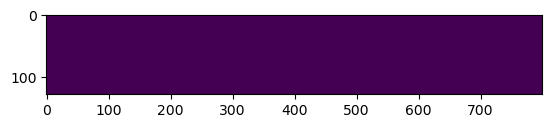

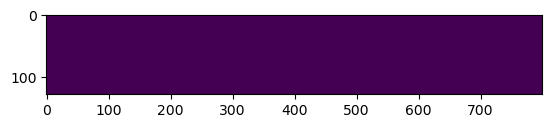

Falla tipo: 3 - IOU: 0.7098420858383179 - DICE: 0.830277144908905


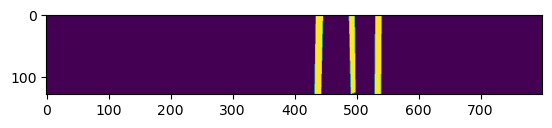

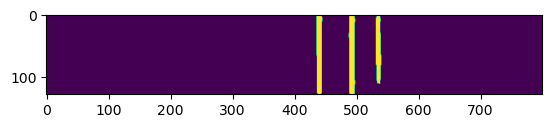

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


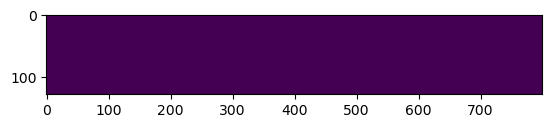

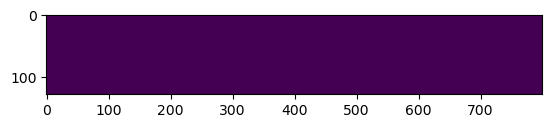

Mean IOU: 0.9274605214595795
Mean DICE: 0.9575693011283875
Keras-IOU: 0.780254602432251

Mean IOU Total: 0.7865748886935762
Mean DICE Total: 0.6265733361244201
Keras-IOU Total: 0.8084968328475952


In [65]:
test_generator = data_generator(x_test,batch_size=1)

iou_total = 0
iou_keras_total = 0
dice_total = 0

for i in range(10):
    data_test = next(test_generator)
    prediction=model2.predict(data_test[0])
    plt.imshow(data_test[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    iou = 0
    dice_1 = 0

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        
        y_pred = (y_pred[:, :] > 0.5) * y_pred
        print(f"Falla tipo: {j+1} - "
              f"IOU: {iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)} - "
              f"DICE: {dice_coef(y_true, y_pred)}")
        iou += iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
        dice_1 += dice_coef(y_true, y_pred)
        plt.imshow(y_true)
        plt.show()
        plt.imshow(y_pred)
        plt.show()
        
        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
        
    print(f"Mean IOU: {iou/4}")
    print(f"Mean DICE: {dice_1/4}")
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()
    #m.update_state([data_test[1][0][:,:,0], data_test[1][0][:,:,1], data_test[1][0][:,:,2], data_test[1][0][:,:,3]],
    #                [prediction[0][:,:,0], prediction[0][:,:,1], prediction[0][:,:,2], prediction[0][:,:,3]]).numpy()
    print(f"Keras-IOU: {m.result().numpy()}")
    
    iou_total += iou/4
    iou_keras_total += dice_1/4
    dice_total += m.result().numpy()
    
print()
print(f"Mean IOU Total: {iou_total/10}")
print(f"Mean DICE Total: {dice_total/10}")
print(f"Keras-IOU Total: {iou_keras_total/10}")

In [57]:
test_generator = data_generator(x_test,batch_size=1)

tpn=0
total = 0
intersection = 0
union = 0
acum_sum=0

for i in range(len(x_test)):
    
    data_test = next(test_generator)
    y_true = data_test[1]
    y_pred =  model2.predict(data_test[0])
    y_pred = (y_pred[:, :] > 0.5) * y_pred

    #Pixel Accuracy
    tpn += np.sum(y_true==y_pred) / y_true.shape[3]
    total += y_true.shape[1]*y_true.shape[2]
    
    intersection += np.sum(y_true * y_pred,axis=(1,2))
    union += np.sum(np.logical_or(y_true,y_pred), axis=(1,2))
    
    acum_sum += np.sum(y_true, axis=(1,2)) + np.sum(y_pred, axis=(1,2))
    
pixel_accuracy = tpn/total

union[union==0]=1
mean_iou = (intersection / union)
    
acum_sum[acum_sum==0]=1
dice = (2* intersection / acum_sum)

In [35]:
test_generator = data_generator(all_img,batch_size=1)

tpn=0
total = 0
intersection = 0
union = 0
acum_sum=0
dice2=0

for i in range(len(all_img)):
    
    data_test = next(test_generator)
    y_true = data_test[1]
    y_pred = model2.predict(data_test[0])
    y_pred = (y_pred[:, :] > 0.5) * y_pred
    
    #Pixel Accuracy
    tpn += np.sum(y_true==y_pred) / y_true.shape[3]
    total += y_true.shape[1]*y_true.shape[2]
    
    intersection += np.sum(y_true * y_pred,axis=(1,2))
    union += np.sum(np.logical_or(y_true,y_pred), axis=(1,2))
    
    acum_sum += np.sum(y_true, axis=(1,2)) + np.sum(y_pred, axis=(1,2))
    
    dice2 += dice_loss(y_true,model2.predict(data_test[0]))
    
    
pixel_accuracy = tpn/total

union[union==0]=1
mean_iou = (intersection / union)
    
acum_sum[acum_sum==0]=1
dice = (2* intersection / acum_sum)

In [29]:
test_generator = data_generator(x_test,batch_size=1)

iou_total = 0
iou_keras_total = 0
dice_total = 0

for i in range(len(x_test)):
    data_test = next(test_generator)
    prediction=model2.predict(data_test[0])
    
    iou = 0
    dice_1 = 0

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        y_pred = (y_pred[:, :] > 0.5) * y_pred
        
        print(f"Falla tipo: {j+1} - IOU: {iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1).numpy()} - DICE: {dice_coef(y_true, y_pred).numpy()}")
        print(f"Interseccion: {K.sum(K.abs(y_true * y_pred))}")
        iou += iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1).numpy()
        dice_1 += dice_coef(y_true, y_pred).numpy()

        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()
    
    print(f"Mean IOU: {iou/4}")
    print(f"Mean DICE: {dice_1/4}")
    print(f"Keras-IOU: {m.result().numpy()}")
    print()
    iou_total += iou/4
    iou_keras_total += dice_1/4
    dice_total += m.result().numpy()

print(f"Mean IOU Total: {iou_total/len(x_test)}")
print(f"Mean DICE Total: {dice_total/len(x_test)}")
print(f"Keras-IOU Total: {iou_keras_total/len(x_test)}")

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.000815328152384609 - DICE: 0.000815328152384609
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7502038320380962
Mean DICE: 0.7502038320380962
Keras-IOU: 0.49858397245407104

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0007920791977085173 - DICE: 0.0007920791977085173
Falla tipo: 4 - IOU: 0.5089337229728699 - DICE: 0.6745125651359558
Mean IOU: 0.6274314505426446
Mean DICE: 0.6688261610834161
Keras-IOU: 0.6372185945510864

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.22005729377269745 - DICE: 0.36006131768226624
Falla tipo: 4 - IOU: 0.015238543041050434 - DICE: 0.015238543041050434
Mean IOU: 0.558823959203437
Mean DICE: 0.5938249651808292
Keras-IOU: 0.49925535917282104

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8297469019889832 - DIC

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.1311844438314438 - DICE: 0.23189258575439453
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.782796110957861
Mean DICE: 0.8079731464385986
Keras-IOU: 0.48360228538513184

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.2774776518344879 - DICE: 0.4339292049407959
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.819369412958622
Mean DICE: 0.858482301235199
Keras-IOU: 0.49964356422424316

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.1768917739391327 - DICE: 0.30059364438056946
Falla tipo: 4 - IOU: 0.0001477346959291026 - DICE: 0.0001477346959291026
Mean IOU: 0.5442598771587654
Mean DICE: 0.5751853447691246
Keras-IOU: 0.46997448801994324

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 0.0009689922444522381 - DICE: 0.0009689922444522381
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo:

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.4551788866519928 - DICE: 0.6251963376998901
Falla tipo: 4 - IOU: 6.433697853935882e-05 - DICE: 6.433697853935882e-05
Mean IOU: 0.613810805907633
Mean DICE: 0.6563151686696074
Keras-IOU: 0.49856579303741455

Falla tipo: 1 - IOU: 0.00179131212644279 - DICE: 0.00179131212644279
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7504478280316107
Mean DICE: 0.7504478280316107
Keras-IOU: 0.49937012791633606

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.001106662442907691 - DICE: 0.001106662442907691
Falla tipo: 4 - IOU: 0.7215198874473572 - DICE: 0.8382085561752319
Mean IOU: 0.6806566374725662
Mean DICE: 0.7098288046545349
Keras-IOU: 0.8001977205276489

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.5630471706390381 - DICE: 0

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0006078103906475008 - DICE: 0.0006078103906475008
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7501519525976619
Mean DICE: 0.7501519525976619
Keras-IOU: 0.4980786144733429

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6531438231468201 - DICE: 0.7901656627655029
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.913285955786705
Mean DICE: 0.9475414156913757
Keras-IOU: 0.7754653692245483

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.19747668504714966 - DICE: 0.329721063375473
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7993691712617874
Mean DICE: 0.8324302658438683
Keras-IOU: 0.5871754884719849

Falla tipo: 1 - IOU: 1.0 - DICE: 1.

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.002406738931313157 - DICE: 0.002406738931313157
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7506016847328283
Mean DICE: 0.7506016847328283
Keras-IOU: 0.49957275390625

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.35097938776016235 - DICE: 0.5195532441139221
Falla tipo: 4 - IOU: 0.0005949315964244306 - DICE: 0.0005949315964244306
Mean IOU: 0.5878935798391467
Mean DICE: 0.6300370439275866
Keras-IOU: 0.5308964848518372

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.5097351670265198 - DICE: 0.6752082705497742
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8774337917566299
Mean DICE: 0.9188020676374435
Keras-IOU: 0.5182768702507019

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU:

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.5266857147216797 - DICE: 0.6899493336677551
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8816714286804199
Mean DICE: 0.9224873334169388
Keras-IOU: 0.6292609572410583

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0019714145455509424 - DICE: 0.0019714145455509424
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7504928536363877
Mean DICE: 0.7504928536363877
Keras-IOU: 0.49943602085113525

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.4561145305633545 - DICE: 0.6264700293540955
Falla tipo: 4 - IOU: 0.00024329818552359939 - DICE: 0.00024329818552359939
Mean IOU: 0.6140894571872195
Mean DICE: 0.6566783318849048
Keras-IOU: 0.6370381116867065

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.1197894737124443 - DICE: 0.21314577758312225
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU:

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.1160978376865387 - DICE: 0.20801840722560883
Falla tipo: 4 - IOU: 0.00017895847850013524 - DICE: 0.00017895847850013524
Mean IOU: 0.5290691990412597
Mean DICE: 0.5520493414260272
Keras-IOU: 0.46551352739334106

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.5735346078872681 - DICE: 0.7289307117462158
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.893383651971817
Mean DICE: 0.932232677936554
Keras-IOU: 0.7392377853393555

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 0.00013582374958787113 - DICE: 0.00013582374958787113
Mean IOU: 0.750033955937397
Mean DICE: 0.750033

Falla tipo: 1 - IOU: 0.0007798791048116982 - DICE: 0.0007798791048116982
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0006347191520035267 - DICE: 0.0006347191520035267
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.5003536495642038
Mean DICE: 0.5003536495642038
Keras-IOU: 0.49668335914611816

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7927500605583191 - DICE: 0.8843525052070618
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9481875151395798
Mean DICE: 0.9710881263017654
Keras-IOU: 0.8830206394195557

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.3320580720901489 - DICE: 0.49853432178497314
Falla tipo: 4 - IOU: 0.0010918322950601578 - DICE: 0.0010918322950601578
Mean IOU: 0.5832874760963023
Mean DICE: 0.6249065385200083
Keras-IOU: 0.5481514930725098

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.05311877653002739 -

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0008806693367660046 - DICE: 0.0008806693367660046
Falla tipo: 4 - IOU: 0.034067023545503616 - DICE: 0.034067023545503616
Mean IOU: 0.5087369232205674
Mean DICE: 0.5087369232205674
Keras-IOU: 0.49869629740715027

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0008183306199498475 - DICE: 0.0008183306199498475
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7502045826549875
Mean DICE: 0.7502045826549875
Keras-IOU: 0.49861571192741394

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8415671586990356 - DICE: 0.9139449000358582
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9603917896747589
Mean DICE: 0.978

Falla tipo: 1 - IOU: 0.0005496015655808151 - DICE: 0.0005496015655808151
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7501374003913952
Mean DICE: 0.7501374003913952
Keras-IOU: 0.49793580174446106

Falla tipo: 1 - IOU: 0.001612903201021254 - DICE: 0.001612903201021254
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7504032258002553
Mean DICE: 0.7504032258002553
Keras-IOU: 0.4992993175983429

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7513421177864075 - DICE: 0.8580015897750854
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9378355294466019
Mean DICE: 0.9645003974437714
Keras-IOU: 0.8380913734436035

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.371126264333725 - DICE: 0.5408669114112854
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8104888796806335 - DICE: 0.8953117728233337
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9526222199201584
Mean DICE: 0.9738279432058334
Keras-IOU: 0.8539841175079346

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7856506109237671 - DICE: 0.8799494504928589
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9464126527309418
Mean DICE: 0.9699873626232147
Keras-IOU: 0.868442714214325

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.545954704284668 - DICE: 0.7061232924461365
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.886488676071167
Mean DICE: 0.9265308231115341
Keras-IOU: 0.7210496664047241

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0008355964091606438 - DICE: 0.0008355964091606438
Falla tipo: 4 - IOU: 0.00035670207580551505 - DICE: 0.00035670207580551505
Mean IOU: 0.50

Falla tipo: 1 - IOU: 0.004530011210590601 - DICE: 0.004530011210590601
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7511325028026477
Mean DICE: 0.7511325028026477
Keras-IOU: 0.4997534155845642

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8520960807800293 - DICE: 0.9201096892356873
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9630240201950073
Mean DICE: 0.9800274223089218
Keras-IOU: 0.9195627570152283

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.06421443074941635 - DICE: 0.12066585570573807
Falla tipo: 4 - IOU: 4.086690751137212e-05 - DICE: 4.086690751137212e-05
Mean IOU: 0.5160638244142319
Mean DICE: 0.5301766806533124
Keras-IOU: 0.4271744191646576

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 0.004530011210590601 - DICE: 0.004530011210590601
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tip

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6299302577972412 - DICE: 0.7729347348213196
Falla tipo: 4 - IOU: 0.0023058673832565546 - DICE: 0.0023058673832565546
Mean IOU: 0.6580590312951244
Mean DICE: 0.693810150551144
Keras-IOU: 0.5982769727706909

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0004407713422551751 - DICE: 0.0004407713422551751
Falla tipo: 4 - IOU: 0.00832356233149767 - DICE: 0.00832356233149767
Mean IOU: 0.5021910834184382
Mean DICE: 0.5021910834184382
Keras-IOU: 0.4973413050174713

Falla tipo: 1 - IOU: 0.0011431837920099497 - DICE: 0.0011431837920099497
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7502857959480025
Mean DICE: 0.7502857959480025
Keras-IOU: 0.49904051423072815

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7706566452980042 - DICE: 0.8704553842544556
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.942664161324501
Mean DICE: 0.9676138460636139
Keras-IOU: 0.8216457962989807

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.2869933247566223 - DICE: 0.44596171379089355
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8217483311891556
Mean DICE: 0.8614904284477234
Keras-IOU: 0.5926339030265808

Falla tipo: 1 - IOU: 0.004981319885700941 - DICE: 0.004981319885700941
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.00042789900908246636 - DICE: 0.00042789900908246636
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.5013523047236959
Mean DICE: 0.5013523047236959
Keras-IOU: 0.4970947206020355

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.2894665002822876 - DICE: 0.4489631652832031
Falla tipo: 4 - IOU: 0.0008845991105772555 - DICE:

Falla tipo: 1 - IOU: 0.0012519562151283026 - DICE: 0.0012519562151283026
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7503129890537821
Mean DICE: 0.7503129890537821
Keras-IOU: 0.49907469749450684

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.10483938455581665 - DICE: 0.18958066403865814
Falla tipo: 4 - IOU: 0.4658541977405548 - DICE: 0.6355512142181396
Mean IOU: 0.6426733955740929
Mean DICE: 0.7062829695641994
Keras-IOU: 0.6120073795318604

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.4148672819137573 - DICE: 0.5863806009292603
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8537168204784393
Mean DICE: 0.8965951502323151
Keras-IOU: 0.6956819891929626

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.46375855803489685 - DICE: 0.6336206793785095
Falla tipo: 4 -

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6733922362327576 - DICE: 0.8048009872436523
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9183480590581894
Mean DICE: 0.9512002468109131
Keras-IOU: 0.8479306697845459

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6365821361541748 - DICE: 0.777879536151886
Falla tipo: 4 - IOU: 0.008145049214363098 - DICE: 0.008145049214363098
Mean IOU: 0.6611817963421345
Mean DICE: 0.6965061463415623
Keras-IOU: 0.49871766567230225

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.4020330607891083 - DICE: 0.5734831094741821
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8505082651972771
Mean DICE: 0.8933707773685455
Keras-IOU: 0.6565977931022644

Falla 

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.00031215857597999275 - DICE: 0.00031215857597999275
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.750078039643995
Mean DICE: 0.750078039643995
Keras-IOU: 0.4962719678878784

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8290480971336365 - DICE: 0.9065133929252625
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9572620242834091
Mean DICE: 0.9766283482313156
Keras-IOU: 0.9254961013793945

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 0.7371098399162292 - DICE: 0.8486307263374329
Mean IOU: 0.9342774599790573
Mean DICE: 0.9621576815843582
Keras-IOU: 0.9342504739761353

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.8719192743301392 - DICE: 0.9315634369850159
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0008881036774255335 - DICE: 0.0008881036774255335
Falla tipo: 4 - IOU: 0.8857684135437012 - DICE: 0.9394203424453735
Mean IOU: 0.7216641293052817
Mean DICE: 0.7350771115306998
Keras-IOU: 0.7977166175842285

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7597522139549255 - DICE: 0.8634700179100037
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9399380534887314
Mean DICE: 0.9658675044775009
Keras-IOU: 0.8284996747970581

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.346731036901474 - DICE: 0.5147547125816345
Falla tipo: 4 - IOU: 0.03191689774394035 - DICE: 0.03191689774394035
Mean IOU: 0.5946619836613536
Mean DICE: 0.6366679025813937
Keras-IOU: 0.5713022351264954

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6242221593856812 - DICE: 0.76863

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 0.00042114657117053866 - DICE: 0.00042114657117053866
Mean IOU: 0.7501052866427926
Mean DICE: 0.7501052866427926
Keras-IOU: 1.0

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.015152303501963615 - DICE: 0.029733970761299133
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7537880758754909
Mean DICE: 0.7574334926903248
Keras-IOU: 0.4904406666755676

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.177060067653656 - DICE: 0.3006432354450226
Falla tipo: 4 - IOU: 0.6660974621772766 - DICE: 0.7995775938034058
Mean IOU: 0.7107893824577332
Mean DICE: 0.7750552073121071
Keras-IOU: 0.644737184047699

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 0.6846390962600708 - DICE: 0.8127954602241516
Mean IOU: 0.9211597740650177
M

Mean IOU: 0.9369505345821381
Mean DICE: 0.9639205783605576
Keras-IOU: 0.7831234931945801

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.000684462720528245 - DICE: 0.000684462720528245
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7501711156801321
Mean DICE: 0.7501711156801321
Keras-IOU: 0.4983203113079071

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.24375608563423157 - DICE: 0.3918997645378113
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8109390214085579
Mean DICE: 0.8479749411344528
Keras-IOU: 0.564959704875946

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.000565064896363765 - DICE: 0.000565064896363765
Falla tipo: 4 - IOU: 0.008673949167132378 - DICE: 0.008673949167132378
Mean IOU: 0.502309753515874
Mean DICE: 0.502309753515874
Keras-IOU: 0.4996655285358429

Falla tipo: 1 - IOU: 0.0006317119114100933 - DICE: 0.0006317119114

Mean IOU: 0.8318660855293274
Mean DICE: 0.8733330443501472
Keras-IOU: 0.4947522282600403

Falla tipo: 1 - IOU: 0.0005506607703864574 - DICE: 0.0005506607703864574
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7501376651925966
Mean DICE: 0.7501376651925966
Keras-IOU: 0.49797117710113525

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.001972019439563155 - DICE: 0.001972019439563155
Falla tipo: 4 - IOU: 0.5507066249847412 - DICE: 0.7102590203285217
Mean IOU: 0.6381696611060761
Mean DICE: 0.6780577599420212
Keras-IOU: 0.6694117784500122

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.26769447326660156 - DICE: 0.4223119914531708
Falla tipo: 4 - IOU: 0.00019689580949489027 - DICE: 0.00019689580949489027
Mean IOU: 0.5669728422690241
Mean DICE: 0.6056272218156664
Keras-IOU: 0.5377030372619629

Falla tipo: 1 - IOU: 1.0 -

Mean IOU: 0.8978462964296341
Mean DICE: 0.9357833117246628
Keras-IOU: 0.7831186056137085

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.23605570197105408 - DICE: 0.3817482888698578
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8090139254927635
Mean DICE: 0.8454370722174644
Keras-IOU: 0.4971289038658142

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.37783777713775635 - DICE: 0.5482837557792664
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.8444594442844391
Mean DICE: 0.8870709389448166
Keras-IOU: 0.6646220684051514

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0009199631749652326 - DICE: 0.0009199631749652326
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7502299907937413
Mean DICE: 0.7502299907937413
Keras-IOU: 0.4987548887729645

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0

Mean IOU: 0.881803035736084
Mean DICE: 0.9225896447896957
Keras-IOU: 0.7807305455207825

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7597970366477966 - DICE: 0.8634862899780273
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9399492591619492
Mean DICE: 0.9658715724945068
Keras-IOU: 0.8701831698417664

Falla tipo: 1 - IOU: 0.001123595517128706 - DICE: 0.001123595517128706
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7502808988792822
Mean DICE: 0.7502808988792822
Keras-IOU: 0.49897947907447815

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.06779953092336655 - DICE: 0.1269480139017105
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.7669498827308416
Mean DICE: 0.7817370034754276
Keras-IOU: 0.49135908484458923

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.016

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.00018330125021748245 - DICE: 0.00018330125021748245
Falla tipo: 4 - IOU: 0.6445714831352234 - DICE: 0.7838646173477173
Mean IOU: 0.6611886960963602
Mean DICE: 0.6960119796494837
Keras-IOU: 0.6383687853813171

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.7610429525375366 - DICE: 0.8642920255661011
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9402607381343842
Mean DICE: 0.9660730063915253
Keras-IOU: 0.7760523557662964

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.6877990961074829 - DICE: 0.8149845600128174
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 0.9219497740268707
Mean DICE: 0.9537461400032043
Keras-IOU: 0.7770023345947266

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.0015929908258840442 - DICE: 0.0015929908258840442
Falla tipo:

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.00040120360790751874 - DICE: 0.00040120360790751874
Falla tipo: 4 - IOU: 0.7408847212791443 - DICE: 0.8511554598808289
Mean IOU: 0.685321481221763
Mean DICE: 0.7128891658721841
Keras-IOU: 0.7623772621154785

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 0.023143265396356583 - DICE: 0.0451652817428112
Falla tipo: 4 - IOU: 0.7379682064056396 - DICE: 0.8492212295532227
Mean IOU: 0.6902778679504991
Mean DICE: 0.7235966278240085
Keras-IOU: 0.5793828964233398

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0
Falla tipo: 2 - IOU: 1.0 - DICE: 1.0
Falla tipo: 3 - IOU: 1.0 - DICE: 1.0
Falla tipo: 4 - IOU: 1.0 - DICE: 1.0
Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0

Mean IOU Total: 0.7820454426274615
Mean DICE Total: 0.6474697020625548
Keras-IOU Total: 0.8012750002980523


In [58]:
union

array([[  87567,   20306, 3404588, 1087318]])

In [59]:
pixel_accuracy

0.9882718436009877

In [60]:
mean_iou

array([[0.        , 0.        , 0.34953378, 0.46867476]])

In [61]:
dice

array([[0.       , 0.       , 0.5258644, 0.6422713]], dtype=float32)